# Deep Learning for Computer Vision:  HW 3


## Computer Science: COMS W 4995 004


### Due: October 20, 2020

Hi all, here is a check list(rough rubric) for HW3.
This is pretty much the same as what questions asked. You might want to check all those below
before submit your HW.

a)  60 points
Will be focusing on whether you satisfied all required conditions when building and training your network. Points will be (roughly) evenly allocated to the following conditions.
1. If you implemented each (hidden, output, loss) layer type as separate classes and had all mentioned functions for each class.
2. If you Implement a MLP class with all mentioned functions.
3. If you used the required activation function.
4. If you used softmax.
5. If loss is correctly computed.
6. Layers’ dimensions are properly passed as required.
7. Training parameters are properly passed as required.
8. If you used regularization in a correct way
9. Run the network using the same or similar code given in the notebook.

b) 5 points
1. If you densely generated points for the whole plane in a proper way.
2. If you colored the points in a correct way

c) 15 points
If you tried all required parameters and plotted the decision region for each.

d) 20 points
1. If you separated your data
2. If you implemented early stopping correctly
3. If you computed accuracy
It could be changed a bit during grading, but not much. There will be deduction in points if the results are not as expected.
In HW2, there were many students implemented models correct but not trained it enough.  Try to use matrices in minibatch calculations(not calculating individual samples using for loop). Then it will take not too long to train more epochs.

#### Problem

a) You are given two dimensional input from three separate classes. Your task is to implement a multi-layer perceptron (MLP) 3-class classifier with multiple hidden layers and a regularization on the weights. For the activiation function of the hidden units use ReLU or leaky ReLU. For the predictions use softmax on a linear output layer as we did in class. Your loss layer should compute $-\log P(y = i \,|{\bf x})$ where $i$ is the correct label according to the training data.

Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Implement a MLP as its own class, with separate methods for initialization, adding a layer, forward propagation, backpropagation, training and prediction. 

Let the layer dimensions be parameters passed when the network is created.

Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.

Build and run your network using your own constructs. The code for doing this might look like what is shown in the next box below.

b) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the three different labels. 

c) Repeat varying the number of hidden units (3, 8, 16), the number of hidden layers (1 and 3), and the regularization value (0 and some other value of your choosing).

d) Re-use this same network on any data of your own choosing. You can increase the dimensionality of the features space as you like. You can also change the number of classes to just two or more than three to align with your data. Separate your data into three piles: training, testing, and validation. Use your testing data to decide when to stop training if appropriate. Use your validation set to compute the accuracy of you classfier. 

In [1]:
# NN = MLP()
# NN.add_layer('Hidden', dim_in=2, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Hidden', dim_in=16, dim_out=16)
# NN.add_layer('Output', dim_in=16, dim_out=3)
# NN.add_layer('Loss', dim_in=3, dim_out=3)

# loss = NN.train(X, y, epochs=100, bsize=8, alpha=0.0)
# plot_loss(loss)
# plot_decision_regions(NN)

 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.  

#### YOUR CODE MUST BE YOUR OWN.
_______________________________________________________________



Let's start by importing some libraries.

In [2]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Let's make up our 2D data for our three classes.

In [3]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = random.randint(0,1)
    x2 = random.randint(0,1)
    if x1 == 1 and x2 == 0:
        y = 0
    elif x1 == 0 and x2 == 1:
        y = 0
    elif x1 == 0 and x2 == 0:
        y = 1
    else:
        y = 2
    x1 = 1.0 * x1 + 0.20 * np.random.normal()
    x2 = 1.0 * x2 + 0.20 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
    
for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = 1.5 + 0.20 * np.random.normal()
    data.iloc[k,2] = 1

for i in range(int(0.25 *len(data.index))):
    k = np.random.randint(len(data.index)-1)  
    data.iloc[k,0] = 0.5 + 0.20 * np.random.normal()
    data.iloc[k,1] = -0.75 + 0.20 * np.random.normal()
    data.iloc[k,2] = 2
    
# Now let's normalize this data.
data.iloc[:,0] = (data.iloc[:,0] - data['x1'].mean()) / data['x1'].std()
data.iloc[:,1] = (data.iloc[:,1] - data['x2'].mean()) / data['x2'].std()
        
data.head()

,x1,x2,y
0,0.578709,0.606606,2.0
1,-0.452876,-1.326223,2.0
2,0.285009,0.626152,2.0
3,1.281510,1.011008,1.0
4,0.995169,0.979233,2.0


Let's message this data into a numpy format.

In [4]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [5]:
# Sloppy function for plotting our data
def plot_data(X, y_predict):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    indices_0 = [k for k in range(0, X.shape[0]) if y_predict[k] == 0]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k] == 1]
    indices_2 = [k for k in range(0, X.shape[0]) if y_predict[k] == 2]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')
    ax.plot(X[indices_2, 0], X[indices_2,1], marker='o', linestyle='', ms=5, label='2')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Tricky 3 Class Classification')
    plt.show()

Now let's plot it.

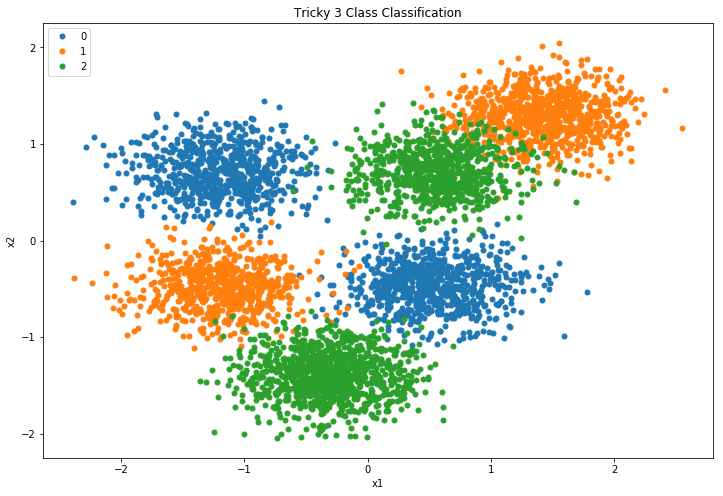

In [6]:
plot_data(X, y)

Now build your network. Good luck! 😉 

Change `X` and `y` into `ndarray` and do sanity check

In [7]:
X = np.array(X)
y = np.array(y)

assert X.shape == (5000, 2)
print(X[0:10])

assert y.shape == (5000, 1)
print(y[0:10])

[[ 0.57870888  0.60660647]
 [-0.45287611 -1.32622344]
 [ 0.28500944  0.62615212]
 [ 1.28151031  1.01100825]
 [ 0.99516894  0.97923293]
 [ 0.51059403 -0.37090693]
 [ 1.22853857  1.08470761]
 [-0.57343465 -1.31288028]
 [ 0.17580847 -0.19453161]
 [ 1.71060256  0.99208966]]
[[2.]
 [2.]
 [2.]
 [1.]
 [2.]
 [0.]
 [1.]
 [2.]
 [0.]
 [1.]]


Flatten `y` and set elements as `integer`. This step is needed to enable slicing through `y` elements.

In [8]:
y = np.array(y.flatten(), dtype='int32')

# Apply `one hot encoding` to `y`, check if the encoding is correct by comparing to the `y` print above

# data = np.array(y.flatten(), dtype='int32')
# shape = (data.size, int(data.max() + 1))

# y = np.zeros(shape)
# rows = np.arange(data.size)

# y[rows, data] = 1
# print(y[0:10])

### a) Implement MLP

#### a.1 Implement each layer type (hidden, output, and loss) as separate python classes, each with methods for initialization, forward propagation, and backpropagation.

Create a base class for `Layer`

In [9]:
from abc import ABC, abstractmethod
 
class Layer(ABC):
 
    def __init__(self, name, dim_in=None, dim_out=None, weight_init='standard', debug=False):
        self.name = name
        
        self.dim_in = dim_in
        self.dim_out = dim_out
     
        if isinstance(self, Input) or isinstance(self, Hidden) or isinstance(self, Output):
            self.weight_init = weight_init
            self.init_weights()
            
        self.debug = debug
        
    def init_weights(self):
        init_method = self.weight_init.lower()
        
        if init_method == 'standard':
            # Init weights using standard random distribution
            self.W = np.random.normal(0, 1, self.dim_in*self.dim_out).reshape(self.dim_in, self.dim_out)
            
        else:
            raise Exception('Non-supported initialization method')
            
        # Set all bias to zeros
        self.b = np.zeros(self.dim_out, dtype='float32')
    
    @abstractmethod
    def forward_propagate(self, X, y=None):
        pass
    
    @abstractmethod
    def back_propagate(self, y_out, y):
        pass

First, create class for `Input`, `Hidden` layer and `Output` layer

In [10]:
class Input(Layer):

    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
        
    def forward_propagate(self, X, y=None):
        return np.dot(X, self.W) + self.b
        
    def back_propagate(self, y_out, y):
        pass

    def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        m = A_prev.shape[1]

        if activation is "relu":
            backward_activation_func = relu_backward
            
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_backward
            
        else:
            raise Exception('Non-supported activation function')

        dZ_curr = backward_activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr
        
class Hidden(Layer):

    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
        
    def forward_propagate(self, X, y=None):
        return np.dot(X, self.W) + self.b
        
    def back_propagate(self, y_out, y):
        pass
    
    def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        m = A_prev.shape[1]

        if activation is "relu":
            backward_activation_func = relu_backward
            
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_backward
            
        else:
            raise Exception('Non-supported activation function')

        dZ_curr = backward_activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr
        
class Output(Layer):
    
    def __init__(self, name, dim_in, dim_out, debug=False):
        super().__init__(name, dim_in, dim_out, debug)
        
    def forward_propagate(self, X, y=None):
        return np.dot(X, self.W) + self.b
        
    def back_propagate(self, y_out, y):
        pass
    
    def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
        m = A_prev.shape[1]

        if activation is "relu":
            backward_activation_func = relu_backward
            
        elif activation is "sigmoid":
            backward_activation_func = sigmoid_backward
            
        else:
            raise Exception('Non-supported activation function')

        dZ_curr = backward_activation_func(dA_curr, Z_curr)
        dW_curr = np.dot(dZ_curr, A_prev.T) / m
        db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
        dA_prev = np.dot(W_curr.T, dZ_curr)

        return dA_prev, dW_curr, db_curr

Then, let's implement the `Activation` and `Loss` classes

In [11]:
class Activation(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    # ReLU for hidden layer
    def apply_relu(self, X): 
        # For ReLU, need to keep X original values
        self.X_linear = np.copy(X)
        
        return np.clip(X, 0, None)

    # Leaky ReLU for hidden layer
    def apply_leaky_relu(self, X, alpha=0.3):
        return np.where(X < 0, alpha * X, X)
    
    # Softmax for output layer
    def apply_softmax(self, X):
        exps = np.exp(X - np.max(X))

        # Check again this line, might be wrong
        sum_exps_1 = np.repeat(exps.sum(axis=1), exps.shape[1]).reshape(exps.shape[0], exps.shape[1])
        
        self.y_probs =  exps / sum_exps_1
    
        return self.y_probs
    
    def compute_relu_derivative(self, y_out, y):
        # CHANGE THIS LATER
        grad = np.copy(y)
        
        return np.where(self.X_linear > 0, grad, 0)
    
    def compute_leaky_relu_derivative(self, y_out, y):
        pass
    
    def compute_softmax_derivative(self, y_out, y):
        # CHANGE THIS LATER
        grad = np.copy(y)
        
        return self.y_probs * (grad - (grad * self.y_probs).sum(axis=1))

    # Wrapper for activations
    def activate(self, X):
        # IMPORTANT: CHECK leaky_relu FIRST
        if 'leaky_relu' in self.name:
            activation_func = self.apply_leaky_relu
        
        elif 'relu' in self.name: 
            activation_func = self.apply_relu
            
        elif 'softmax' in self.name:
            activation_func = self.apply_softmax
        
        else:
            raise Exception('Non-supported activation function')
            
        return activation_func(X)
            
    def forward_propagate(self, X, y=None):
        return self.activate(X)
    
    def back_propagate(self, y_out, y):
        if 'leaky_relu' in self.name:
            derivative_func = self.compute_leaky_relu_derivative
        
        elif 'relu' in self.name:
            derivative_func = self.compute_relu_derivative
            
        elif 'softmax' in self.name:
            derivative_func = self.compute_softmax_derivative
        
        else:
            raise Exception('Non-supported activation function')
            
        return activation_func(y_out, y)

class Loss(Layer):
    
    def __init__(self, name, debug=False):
        super().__init__(name, debug)
        
    # Losses in the output layer
    # X has shape of (num_examples, num_classes)
    # y has shape of (num_examples,)
    # Note that y is simply array of labels, e.g. for three classes: 0, 2, 1, 2, 2, 0],
    # and not a one hot encoded vector
    # IMPORTANT: Apply softmax to X beforehand
    def apply_cross_entropy(self, y_out, y):
        num_examples = y.shape[0]

        log_likelihoods = - np.log(y_out[range(num_examples), y])

        return np.sum(log_likelihoods) / num_examples
    
    # Wrapper for loss
    def compute_loss(self, y_out, y):
        if self.debug:
            print('y_out shape: {}'.format(y_out.shape))
            print('y shape: {}'.format(y.shape))
            
        if 'cross_entropy' in self.name:
            loss_func = self.apply_cross_entropy
            
        else:
            raise Exception('Non-supported loss function')
            
        return loss_func(y_out, y)
            
    def forward_propagate(self, X, y):
        return self.compute_loss(X, y)
    
    def back_propagate(self, y_out, y):
        print('Invalid operation for Loss layer')

def check_activation_and_loss_imp():
    y_out = np.array([1.0, -2.0, 3.0, -5.0])
    
    reluAct = Activation('relu_0')
    leakyReluAct = Activation('leaky_relu_0')
    
    assert (reluAct.activate(y_out) == np.array([1., 0., 3., 0])).all()
    assert (leakyReluAct.activate(y_out) == np.array([ 1. , -0.6,  3. , -1.5])).all()
    
    y_out = np.array([[1.0, 2.0, 3.0], [2.0, 2.0, 2.0]])
    
    softmaxAct = Activation('softmax_0', False)
    y_out_softmax = softmaxAct.activate(y_out)
    print(y_out_softmax.shape)
    
    print(np.sum(y_out_softmax, axis=1))
    
    crossEntropyLoss = Loss('cross_entropy_0')
    assert crossEntropyLoss.compute_loss(y_out_softmax, np.array([0, 2])) == 1.7531091265562448

Sanity checks to see if `Activation` and `Loss` implementation is correct:

In [12]:
check_activation_and_loss_imp()

(2, 3)
[1. 1.]


Finally, an MLP class

In [18]:
class MLP():
    
    #  Let the number of training epochs, the mini-batch size, and the regularization parameter be parameters that are passed when training the network.
    def __init__(self, debug=True):
        self.layers = []
        self.losses = []
        
        self.debug = debug
        
    # Let the layer dimensions be parameters passed when the network is created
    def add_layer(self, layer_type, dim_in=None, dim_out=None, weight_init='standard'):
        layer_type = layer_type.lower()
        
        num_of_layers = sum(layer_type in layer.name for layer in self.layers)
        name = layer_type + '_' + str(num_of_layers)
        
        if layer_type == 'input':
            self.layers.append(Input(name, dim_in, dim_out, weight_init))
            
        elif layer_type == 'hidden':
            self.layers.append(Hidden(name, dim_in, dim_out, weight_init))
        
        elif layer_type == 'output':
            self.layers.append(Output(name, dim_in, dim_out, weight_init))
            
        elif 'activation' in layer_type:
            self.layers.append(Activation(name))
            
        elif 'loss' in layer_type:
            self.layers.append(Loss(name))
        
        else:
            raise Exception('Non-supported layer type')
        
    def forward_propagate(self, X, y):
        if self.debug:
            print('Forward propagating...')
            print('Input shape: {}'.format(X.shape))
        
        for layer in self.layers:
            if self.debug:
                print('Layer name: {}'.format(layer.name))
                    
            if not isinstance(layer, Loss):

                X = layer.forward_propagate(X)

                if self.debug:
                    print('Output shape: {}'.format(X.shape))
                    
            else:
                loss = layer.forward_propagate(X, y)
                
                if self.debug:
                    print('Loss shape: {}'.format(loss.shape))
            
        return loss 
        
    def back_propagate(self, y_out, y, alpha):
        if self.debug:
            print('Back propagating...')
            
        lossLayer = self.layers[len(self.layers)-1]
        loss = lossLayer.back_propagate(y_out, y, alpha)
        
        for layer in reversed(self.layers):
            if not isinstance(layer, Loss):
                if self.debug:
                    print('Layer name: {}'.format(layer.name))

                losses = layer.back_propagate(y_out, y, alpha)

                if self.debug:
                    print('Losses shape: {}'.format(losses.shape))
            
        return loss
    
    def train(self, X, y, epochs, bsize, alpha):
        # IMPORTANT: I assume the last layer as Loss layer
        if not isinstance(self.layers[len(self.layers) - 1], Loss):
            raise Exception('Last layer is not a Loss layer')
            
        losses = []
        
        for i in range(0, epochs):
            loss = 0.0
            num_inputs = 0
            idx_start = 0
            
            while idx_start < X.shape[0]:
                idx_end = idx_start + bsize
                
                # Clip last batches
                if idx_end > X.shape[0]:
                    idx_end = X.shape[0]
                
                X_minbatch, y_minbatch = X[idx_start:idx_end], y[idx_start:idx_end]
                
                loss += self.forward_propagate(X_minbatch, y_minbatch).sum()
            
#                 self.back_propagate(y_out, y, alpha)
                
                idx_start = idx_start + bsize
            
            losses.append(loss / X.shape[0])
        
        return np.array(losses)
    
    def predict(self, X):
        y_out_probs = self.forward_propagate(X)
        
        return np.argmax(y_out_probs, axis=1)
    
    def do_SGD(self, params):
        for param in params:
            param[:] = param - self.lr * param.grad
    

In [19]:
NN = MLP(debug=False)
NN.add_layer('Input', dim_in=2, dim_out=16)
NN.add_layer('Activation_Relu')
NN.add_layer('Hidden', dim_in=16, dim_out=16)
NN.add_layer('Activation_Relu')
NN.add_layer('Output', dim_in=16, dim_out=3)
NN.add_layer('Activation_Softmax')
NN.add_layer('Loss_Cross_Entropy')

losses = NN.train(X, y, epochs=10, bsize=32, alpha=0.0)
# y_out = NN.forward_propagate(X)
# y_outs = NN.predict(X)
# NN.back_propagate(y_out, y)

In [20]:
losses.shape

(10,)

In [21]:
losses[0]

3568.487264008497